In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Load data prepared in Module 3
df = pd.read_csv(
    "final_feature_engineered_data.csv",
    index_col=0,
    parse_dates=True
)

df.head()


,hour,day,month,day_of_week,lag_1,lag_2,lag_3,rolling_mean_3,rolling_mean_6,Energy_Scaled
Timestamp,,,,,,,,,,
2023-01-01 05:00:00,5,1,1,6,0.411342,0.315906,0.706224,0.331581,0.412218,0.267497
2023-01-01 06:00:00,6,1,1,6,0.267497,0.411342,0.315906,0.265929,0.382527,0.118949
2023-01-01 07:00:00,7,1,1,6,0.118949,0.267497,0.411342,0.339327,0.408575,0.631535
2023-01-01 08:00:00,8,1,1,6,0.631535,0.118949,0.267497,0.415952,0.373767,0.497372
2023-01-01 09:00:00,9,1,1,6,0.497372,0.631535,0.118949,0.551959,0.408944,0.526971


In [5]:
# For LSTM, we will predict Energy_Scaled using past Energy_Scaled only
energy_values = df['Energy_Scaled'].values.reshape(-1, 1)

energy_values[:5]


array([[0.26749654],
       [0.11894882],
       [0.63153527],
       [0.49737206],
       [0.52697095]])

In [6]:
# Function to create sequences for LSTM
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define number of past hours to look at
TIME_STEPS = 24   # 24 hours

# Create sequences
X, y = create_sequences(energy_values, TIME_STEPS)

X.shape, y.shape


((8755, 24, 1), (8755, 1))

In [7]:
# Train-Test split (time-series safe)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
X_test  = X[split_index:]

y_train = y[:split_index]
y_test  = y[split_index:]

X_train.shape, X_test.shape


((7004, 24, 1), (1751, 24, 1))

In [8]:
# Build LSTM model
model = Sequential()

model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mse')

model.summary()


C:\Users\MOKARA KRISHNA SATYA\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0186 - val_loss: 0.0182
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0186 - val_loss: 0.0182
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 10/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 11/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 12/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# Predict on test data
y_pred = model.predict(X_test)

y_pred[:5]


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([[0.34010786],
       [0.34386894],
       [0.34137318],
       [0.3445051 ],
       [0.3431004 ]], dtype=float32)

In [12]:
# Calculate evaluation metrics for LSTM
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("LSTM Mean Absolute Error (MAE):", mae)
print("LSTM Root Mean Squared Error (RMSE):", rmse)


LSTM Mean Absolute Error (MAE): 0.10610446890690138
LSTM Root Mean Squared Error (RMSE): 0.13403259276984505


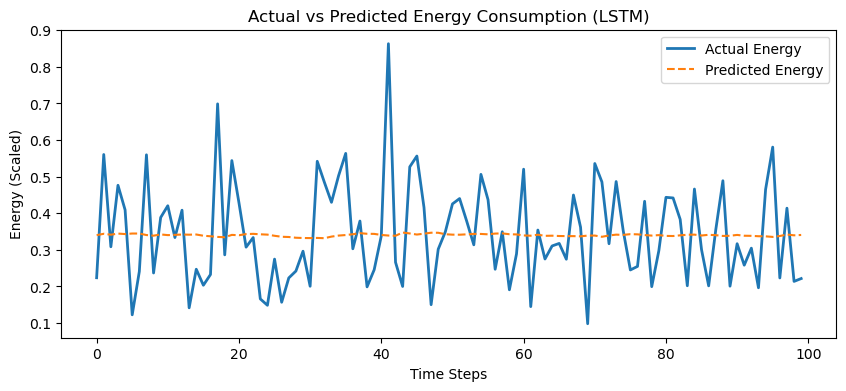

In [13]:
plt.figure(figsize=(10, 4))

plt.plot(y_test[:100], label='Actual Energy', linewidth=2)
plt.plot(y_pred[:100], label='Predicted Energy', linestyle='--')

plt.title("Actual vs Predicted Energy Consumption (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Energy (Scaled)")
plt.legend()
plt.show()
